### Hardware

These models run at half precision (fp16), so you'll need ~2x the parameter count in GPU ram bytes to run without further quantization. I.e. 7b -> 13 gb. A single A10 or A6000 is enough to get started. The largest model (65b) works on 4x A6000 (48gb each) or 2x A100 (80gb each).

You can monitor graphics cards in a terminal with `nvidia-smi -l 1` (refresh every second). If the first GPU ram fills up and then you get a CUDA out of memory error, you may need to manually specify the max memory per card. 

### Models

These models come from the huggingface project `decapoda-research`. Officially though, you're supposed to request access to the weights from Facebook. 
- [X] Submit this request [here](https://docs.google.com/forms/d/e/1FAIpQLSfqNECQnMkycAp2jP4Z9TFX0cGR4uf7b_fBxjY_OjhJILlKGA/viewform)

### Dependencies

`pip install numpy pandas torch datasets transformers matplotlib scikit-learn sentencepiece tqdm accelerate matplotlib`

There's a weird mismatch in the casing of llama (`llama` vs `LLaMA`) that breaks loading these models. The easiest fix I found is just pull some guy's forked version of the `transformers` package that fixes this.

`pip install git+https://github.com/mbehm/transformers`

### Further quantization

`pip install bitsandbytes-cuda117` (replace 117 with your version)

Should see error:

`AttributeError: /home/ubuntu/anaconda3/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cget_col_row_stats`

CD there and `cp libbitsandbytes_cuda117.so libbitsandbytes_cpu.so`! this actually works


  

In [1]:
import sys
import torch
import transformers
from transformers import LLaMATokenizer, LlamaForCausalLM

MODELS = {
  "llama-7b": "decapoda-research/llama-7b-hf",
  "llama-13b": "decapoda-research/llama-13b-hf",
  "llama-30b": "decapoda-research/llama-30b-hf",
  "llama-65b": "decapoda-research/llama-65b-hf"
}

MODEL_TAG = "llama-7b"
MODEL_NAME = MODELS[MODEL_TAG]

tokenizer = LLaMATokenizer.from_pretrained(MODEL_NAME)

model = LlamaForCausalLM.from_pretrained(
    MODEL_NAME,
    # Further quantization (requries BitsAndBytes, experimental). Keep dtype=float16 with this
    # load_in_8bit=LOAD_8BIT,
    torch_dtype=torch.float16,
    # `device_map` maps layers and the lm head to devices they live on. `auto` works, `sequential`
    # and `balance_low0` should work but don't
    device_map="auto",
    # If the first GPU ram fills up and then you get a CUDA out of memory error, you may need to
    # manually specify the max memory per card. I don't know why accelerate / huggingface can't 
    # always infer this. For 4x A6000:
    # max_memory = {0: "44gib", 1: "44gib", 2: "44gib", 3: "44gib"}
)

print("Loaded {}!".format(MODEL_TAG))
print(model)

2023-05-15 17:04:31.473153: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

Loaded llama-7b!


In [2]:
from transformers import GenerationConfig

# Simple generation using huggingface's default interface. This will probably
# produce output that's pretty bad since LLaMA is a foundation model and hasn't
# been tuned on any downstream objective.

# Also doesn't use any smart heuristic for stopping so it will just keep generating
# until it hits the `max_new_tokens`
def generate(
    text,
    temperature=0.1,
    top_p=0.75,
    top_k=40,
    num_beams=4,
    max_new_tokens=128,
    **kwargs,
):
    inputs = tokenizer(text, return_tensors="pt")
    input_ids = inputs["input_ids"].to(model.device)
    generation_config = GenerationConfig(
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        num_beams=num_beams,
        **kwargs,
    )
    with torch.no_grad():
        generation_output = model.generate(
            input_ids=input_ids,
            generation_config=generation_config,
            return_dict_in_generate=True,
            output_scores=True,
            max_new_tokens=max_new_tokens,
        )
    s = generation_output.sequences[0]
    output = tokenizer.decode(s)
    return output

In [3]:
# For messing around with generation

# prefix = input()
# completion = generate(prefix)
# print(completion)

In [4]:
from tqdm import tqdm
import numpy as np

# Extract LLaMA hidden states from some sequence of tokens `input_ids`.
# Returns activations from the layer numbered `layer` (or -1 for last layer)
def llama_hs_from_tokens(model, input_ids, layer=-1):
    with torch.no_grad():
        output = model(input_ids, output_hidden_states=True)

    hs_tuple = output["hidden_states"]
    hs = hs_tuple[layer][0, -1].detach().cpu().numpy()
    
    return hs

# Extract LLaMA hidden states from a string of text.
# Optionally add an EOS token to the end of the input.
# Returns activations from the layer numbered `layer` (or -1 for last layer)
def llama_hs_from_text(model, tokenizer, text, layer=-1, add_eos=True):
    if add_eos:
      text = text + tokenizer.eos_token
    
    input_ids = tokenizer(text, return_tensors="pt").input_ids.to(model.device)

    return llama_hs_from_tokens(model, input_ids, layer)


In [6]:
import copy
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression

from datasets import load_dataset

# Load the amazon polarity dataset. 
# This is stored on google drive (!) and sometimes the download throws
# weird errors. You might need a new version of `datasets` or the drive
# folder might be at its bandwidth limit for the day lol.
data = load_dataset("amazon_polarity")["test"]

Found cached dataset amazon_polarity (/home/fsuser/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/a27b32b7e7b88eb274a8fa8ba0f654f1fe998a87c22547557317793b5d2772dc)


  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
# Make all training data
neg_hs, pos_hs, y, all_text = make_training_data(model, tokenizer, data, format=format_amazon, n=400)

# 50/50 train/test split
n = len(y)
neg_hs_train, neg_hs_test = neg_hs[:n//2], neg_hs[n//2:]
pos_hs_train, pos_hs_test = pos_hs[:n//2], pos_hs[n//2:]
text_train, text_test = all_text[:n//2], all_text[n//2:]
y_train, y_test = y[:n//2], y[n//2:]

100%|██████████| 400/400 [00:36<00:00, 10.97it/s]


In [9]:
# Try simple logistic regression to see if that works.
# Learn a plane that separates differences in the true direction vs differences
# in the false direction.

x_train = neg_hs_train - pos_hs_train
x_test = neg_hs_test - pos_hs_test

lr = LogisticRegression(class_weight="balanced", max_iter=1000)
lr.fit(x_train, y_train)
print("Logistic regression accuracy: {}".format(lr.score(x_test, y_test)))

Logistic regression accuracy: 0.98


In [8]:
# def generate_next_from_set(
#     text,
#     options
# ):
#     inputs = tokenizer(text, return_tensors="pt")
#     option_tokens = [tokenizer(x, return_tensors="pt") for x in options]

#     input_ids = inputs["input_ids"].to(model.device)
#     option_ids = [x["input_ids"].to(model.device) for x in option_tokens]


#     # temperature=0.1,
#     # top_p=0.75,
#     # top_k=40,
#     # num_beams=4,
#     max_new_tokens=128,

#     generation_config = GenerationConfig(
#         temperature=temperature,
#         top_p=top_p,
#         top_k=top_k,
#         num_beams=num_beams,
#     )
#     outputs = model.generate(input_ids, return_dict_in_generate=True, output_scores=True, max_new_tokens=max_new_tokens)

#     transition_scores = model.compute_transition_scores(
#         outputs.sequences, outputs.scores, normalize_logits=False
#     )

#     print(transition_scores)

#     # outputs = model.generate(**inputs, max_new_tokens=5, return_dict_in_generate=True, output_scores=True)
#     # transition_scores = model.compute_transition_scores(
#     #     outputs.sequences, outputs.scores, normalize_logits=True
#     # )

#     # input_length = inputs.input_ids.shape[1]
#     # generated_tokens = outputs.sequences[:, input_length:]
#     # for tok, score in zip(generated_tokens[0], transition_scores[0]):
#     #   # | token | token string | logits | probability
#     #   print(f"| {tok:5d} | {tokenizer.decode(tok):8s} | {score.numpy():.4f} | {np.exp(score.numpy()):.2%}")

#     # with torch.no_grad():
#     #   outputs = model(input_ids)

#     # next_token_logits = outputs["logits"]

#     # print(outputs)

#     # predictions = F.softmax(outputs.logits, dim=-1).detach().cpu()

#     # print(predictions)

#     # thresh = 1e-5
#     # vocab_size = predictions.shape[-1]

#     # # Predictions has one sentence (index 0) and we look at the last token predicted (-1)
#     # idxs = torch.arange(0, vocab_size)[predictions[0][-1] >= thresh]
#     # print(tokenizer.convert_ids_to_tokens(idxs))

#     # with torch.no_grad():
#     #     model()
#     #     generation_output = model.generate(
#     #         input_ids=input_ids,

#     #         return_dict_in_generate=True,
#     #         output_scores=True,
#     #         max_new_tokens=max_new_tokens,
#     #     )
#     # s = generation_output.sequences[0]
#     # output = tokenizer.decode(s)
#     # return output

# labels = []

# for x in tqdm(text_test):
#   text = format_amazon_for_completion(x)

#   tag_ids = tokenizer(["Positive", "Negative"], add_special_tokens=False).input_ids 

#   completion =generate(text, force_words_ids=[tag_ids], max_new_tokens=5)


#   result = completion[len(text):]
#   labels.append(1 if "Positive" in result else 0)

# print(labels)

# predictions = np.array(labels)

# acc = (predictions == y_test).mean()
# acc = max(acc, 1 - acc)
# print("Naive generation accuracy: {}".format(acc))


In [20]:
# Subtract out the mean (and maybe also normalize variance) of a data set
def normalize(x, var_normalize = False):
  normalized_x = x - x.mean(axis=0, keepdims=True)
  if var_normalize:
      normalized_x /= normalized_x.std(axis=0, keepdims=True)

  return normalized_x

# Collin's main loss function
def informative_loss(p0, p1):
  return (torch.min(p0, p1)**2).mean(0)

def consistent_loss(p0, p1):
  return ((p0 - (1-p1))**2).mean(0)

def ccs_loss(p0, p1):
  return informative_loss(p0,p1) + consistent_loss(p0,p1)

def get_tensor_data(x0, x1):
  x0 = torch.tensor(x0, dtype=torch.float, requires_grad=False, device=model.device)
  x1 = torch.tensor(x1, dtype=torch.float, requires_grad=False, device=model.device)
  return x0, x1

# Learn the plane from CCS. For some reason this doesn't always converge so we'll
# do `ntries` runs. 10 seems to be more than enough.
# Returns [best_probe, best_loss]
def ccs(x0, x1, nepochs=1000, ntries=10, lr=1e-3, verbose=False, weight_decay=0.01, var_normalize=False, loss_func=ccs_loss):
    # Collin subtracts out the means before training
    x0 = normalize(x0, var_normalize=var_normalize)
    x1 = normalize(x1, var_normalize=var_normalize)

    # Number of entries in the hidden states
    d = x0.shape[-1]
    
    # Probe that we'll learn
    probe = nn.Sequential(nn.Linear(d, 1),nn.Sigmoid())
    probe.to(model.device)  
    best_probe = copy.deepcopy(probe)
      
    best_loss = np.inf
    
    

    for train_num in range(ntries):
        # Make a new probe for this run
        probe = nn.Sequential(nn.Linear(d, 1), nn.Sigmoid())
        probe.to(model.device)  

        # Order the data randomly in a tensor
        x0, x1 = get_tensor_data(x0, x1)
        permutation = torch.randperm(len(x0))
        x0, x1 = x0[permutation], x1[permutation]
        
        # Set up optimizer. Collin uses adamW so that's what we'll go with
        optimizer = torch.optim.AdamW(probe.parameters(), lr=lr, weight_decay=weight_decay)

        # Start training
        for epoch in range(nepochs):
          # probe
          p0, p1 = probe(x0), probe(x1)

          # get the corresponding loss
          loss = loss_func(p0, p1)

          # update the parameters
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

        loss = loss.detach().cpu().item()
        
        if verbose:
          print("Round {}: loss is {}".format(train_num, loss))
          
        if loss < best_loss:
            best_probe = copy.deepcopy(probe)
            best_loss = loss

    return best_probe, best_loss


def predict_pairs(probe, x0, x1):
  x0 = torch.tensor(x0, dtype=torch.float, requires_grad=False, device=model.device)
  x1 = torch.tensor(x1, dtype=torch.float, requires_grad=False, device=model.device)
  
  with torch.no_grad():
      p0, p1 = probe(x0), probe(x1)

  avg_confidence = p0 - p1
  predictions = (avg_confidence.detach().cpu().numpy())[:,0]
  return predictions

# Get raw credence scores (before sigmoid) from a single hidden state.
# `hs` is a numpy array of hidden states to apply this to
def classify_single(probe, hs):
  # Extract the actual vectors
  classifier_direction = np.squeeze(np.transpose(probe[0].weight.detach().cpu().numpy()))
  confidences = np.apply_along_axis(lambda x : np.dot(x,classifier_direction), 1, hs)

  return confidences

def get_acc(probe, x0_test, x1_test, y_test):
  predictions = (predict_pairs(probe, x0_test, x1_test) < 0.5).astype(int)

  # If predictions get messed up (i.e. ever not 1 or 0) this method will show
  # really good accuracy. TODO evaluate vs y_test and y_test inverted to avoid
  # this.
  acc = (predictions == y_test).mean()

  acc = max(acc, 1 - acc)

  return acc

def is_reversed(probe, x0_test, x1_test, y_test):
  predictions = (predict_pairs(probe, x0_test, x1_test) < 0.5).astype(int)

  # If predictions get messed up (i.e. ever not 1 or 0) this method will show
  # really good accuracy. TODO evaluate vs y_test and y_test inverted to avoid
  # this.
  acc = (predictions == y_test).mean()

  return acc < 0.5




In [21]:
probe, loss = ccs(neg_hs_train, pos_hs_train, ntries=3, verbose=True)

print("Learned probe:\n")
print(np.squeeze(np.transpose(probe[0].weight.detach().cpu().numpy())))
ccs_acc = get_acc(probe, neg_hs_test, pos_hs_test, y_test)

print("CCS Accuracy: {}, loss: {}".format(ccs_acc, loss))

classifier_direction = np.squeeze(np.transpose(probe[0].weight.detach().cpu().numpy()))

neg_credences = np.apply_along_axis(lambda x : np.dot(x,classifier_direction), 1, neg_hs_test)
pos_credences = np.apply_along_axis(lambda x : np.dot(x,classifier_direction), 1, pos_hs_test)

Round 0: loss is 0.0008136031683534384


/tmp/ipykernel_2212/1519275720.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0, dtype=torch.float, requires_grad=False, device=model.device)
/tmp/ipykernel_2212/1519275720.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(x1, dtype=torch.float, requires_grad=False, device=model.device)


Round 1: loss is 0.0007731855730526149
Round 2: loss is 0.0007348332437686622
Learned probe:

[-0.0088816  -0.0011106  -0.05952156 ...  0.00654809  0.02589549
  0.05425652]
CCS Accuracy: 0.96, loss: 0.0007348332437686622


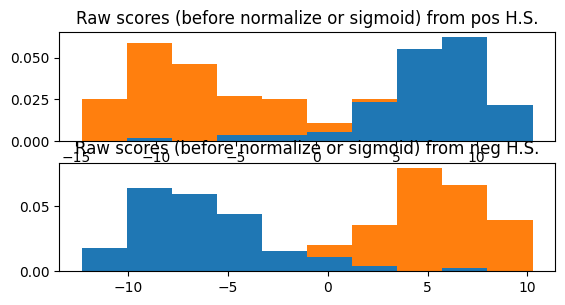

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

plt.subplot(311)
plt.title("Raw scores (before normalize or sigmoid) from pos H.S.")
plt.hist([pos_credences[[(not not x) for x in y_test]], pos_credences[[not x for x in y_test]]], stacked=True, density=True)

plt.subplot(312)
plt.title("Raw scores (before normalize or sigmoid) from neg H.S.")
plt.hist([neg_credences[[(not not x) for x in y_test]], neg_credences[[not x for x in y_test]]], stacked=True, density=True)

plt.show()

In [12]:
# For playing around with random statements


# print(is_reversed(probe, neg_hs_test, pos_hs_test, y_test))

# def sig(x):
#  return 1/(1 + np.exp(-x))

# while(True):
#     t = input()
#     hs = get_llama_hidden_states(model, tokenizer, t)
#     raw = np.dot(classifier_direction, hs)
#     print("'{}' scores {} (sigmoid {})".format(t, raw, sig(raw)))

In [26]:
# Component of x perpendicular to y
def perp(x,y):
  along = y * (np.dot(x,y) / np.dot(y,y))
  return x - along

residual_neg_hs_train = neg_hs_train
residual_pos_hs_train = pos_hs_train

residual_neg_hs_test = neg_hs_test
residual_pos_hs_test = pos_hs_test

accs = []
train_accs = []
losses = []
probes = []


for i in range(5):
  probe, loss = ccs(residual_neg_hs_train, residual_pos_hs_train, ntries=5, loss_func=ccs_loss)

  ccs_acc = get_acc(probe, residual_neg_hs_test, residual_pos_hs_test, y_test)
  ccs_train_acc = get_acc(probe, residual_neg_hs_train, residual_pos_hs_train, y_train)
  
  print("CCS accuracy (component {}): {} in training, {} in testing, {} loss".format(i,ccs_train_acc,ccs_acc, loss))

  train_accs.append(ccs_train_acc)
  accs.append(ccs_acc)
  losses.append(loss)
  probes.append(probe)

  # The direction we just found that best classifies the data
  classifier_direction = np.squeeze(np.transpose(probe[0].weight.detach().cpu().numpy()))

  residual_neg_hs_train = np.apply_along_axis(lambda x : perp(x,classifier_direction), 1, residual_neg_hs_train)
  residual_pos_hs_train = np.apply_along_axis(lambda x : perp(x,classifier_direction), 1, residual_pos_hs_train)
  residual_neg_hs_test = np.apply_along_axis(lambda x : perp(x,classifier_direction), 1, residual_neg_hs_test)
  residual_pos_hs_ttest = np.apply_along_axis(lambda x : perp(x,classifier_direction), 1, residual_pos_hs_test)



/tmp/ipykernel_2212/1519275720.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0, dtype=torch.float, requires_grad=False, device=model.device)
/tmp/ipykernel_2212/1519275720.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(x1, dtype=torch.float, requires_grad=False, device=model.device)


CCS accuracy (component 0): 0.93 in training, 0.955 in testing, 0.0006360188126564026 loss
CCS accuracy (component 1): 0.575 in training, 0.54 in testing, 0.001127599854953587 loss
CCS accuracy (component 2): 0.545 in training, 0.54 in testing, 0.0022196657955646515 loss
CCS accuracy (component 3): 0.555 in training, 0.505 in testing, 0.002310703042894602 loss
CCS accuracy (component 4): 0.55 in training, 0.515 in testing, 0.003679388901218772 loss


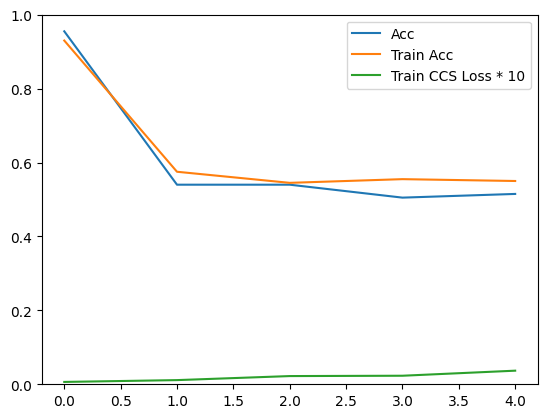

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

plt.plot(accs, label='Acc')
plt.plot(train_accs, label='Train Acc')
plt.plot(np.array(losses) * 10, label='Train CCS Loss * 10')
plt.legend()
plt.ylim(0,1)


plt.show()

# Weird stuff going on here...

- Potentially overfitting?
- Training accuracy can be slightly worse (!) than test accuracy

In [28]:
# Hoverable view (broken in this notebook)
# def plot_component_classification(preds1, preds2, y_real, texts):
#   fig = plt.figure()
#   ax = fig.add_subplot()

#   # Make the grid
#   x, y = np.meshgrid(np.arange(-1, 1, 0.1),
#                         np.arange(-1, 1, 0.1))
    
#   colors = ["red" if y == 0  else "green" for y in y_real]
#   sc = ax.scatter(preds1, preds2, color=colors)
    
#   # setting title and labels
#   ax.set_title("Test Classsification")
#   ax.set_xlabel('Component 0')
#   ax.set_ylabel('Component 1')

#   annot = ax.annotate("", xy=(0,0), xytext=(4,4),textcoords="offset points",
#                       bbox=dict(boxstyle="round", fc="w"),
#                       arrowprops=dict(arrowstyle="->"))
#   annot.set_color("white")
#   annot.set_fontsize(8)
#   annot.set_wrap(True)
#   annot.get_bbox_patch().set_facecolor("black")
#   annot.get_bbox_patch().set_alpha(0.8)
#   annot.set_visible(False)
  
#   def update_annot(ind):
#       pos = sc.get_offsets()[ind["ind"][0]]
#       annot.xy = pos
#       text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
#                             " ".join([texts[n] for n in ind["ind"]]))
#       annot.get_bbox_patch().set_facecolor("red" if y_real[ind["ind"][0]] == 0 else "green")
#       annot.set_text(text)
    
#   def hover(event):
#       vis = annot.get_visible()
#       if event.inaxes == ax:
#           cont, ind = sc.contains(event)
#           if cont:
#               update_annot(ind)
#               annot.set_visible(True)
#               fig.canvas.draw_idle()
#           else:
#               if vis:
#                   annot.set_visible(False)
#                   fig.canvas.draw_idle()

#   fig.canvas.mpl_connect("motion_notify_event", hover)

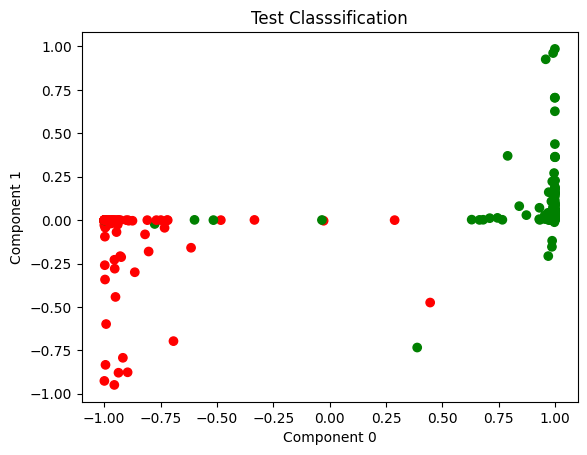

In [29]:

preds1 = predict_pairs(probes[0], pos_hs_test, neg_hs_test)
preds2 =  predict_pairs(probes[1], pos_hs_test, neg_hs_test)
# preds3 =   predict(probes[1], pos_hs_test, neg_hs_test)

# preds4 = predict(probes[0], pos_hs_train, neg_hs_train)
# preds5 = predict(probes[0], pos_hs_train, neg_hs_train)
# preds6 = predict(probes[0], pos_hs_train, neg_hs_train)
plot_component_classification(preds1, preds2, y_test, text_test)



In [30]:
# examples = [
#     # "The sky is red.",
#     # "The sky is blue.",
#     # "Roses are red.",
#     # "Roses are blue.",
#     # "France is in Europe.",
#     # "The United States is in Europe.",
#     # "France is in Asia.",
#     # "The United States is in Asia.",
#     # "George Washington was the first president.",
#     # "George Strait was the first president.",
#     # "George Washington was a country singer.",
#     # "George Strait was a country singer.",
#     # "China is in Asia",
#     # "Japan is in Asia",
#     "The sky is red",
#     "The sky is orange",
#     "The sky is yellow",
#     "The sky is green",
#     "The sky is blue",
#     "The sky is purple",
#     "The sky is black",
# ]

# true_ex = ["Evaluate the following statement: " + x + " This statement is true." for x in examples]
# false_ex = ["Evaluate the following statement: " + x + " This statement is false." for x in examples]
# labels = [0,1,1,0,1,0,0,0,1,0,0,1,1,1]

# true_hs = np.array([get_llama_hidden_states(model, tokenizer, x) for x in true_ex])
# false_hs = np.array([get_llama_hidden_states(model, tokenizer, x) for x in false_ex])

# classifications1 = predict(probes[0],true_hs, false_hs)
# classifications2 = predict(probes[1], true_hs, false_hs)


# plot_component_classification(classifications1, classifications2,  labels, examples)



In [38]:
prompt = "The capital of the United States is Washington"
tokenizer.pad_token_id = tokenizer.eos_token_id
inputs = tokenizer([prompt], return_tensors="pt")

# Example 1: Print the scores for each token generated with Greedy Search
outputs = model.generate(inputs["input_ids"].to(model.device),
    return_dict_in_generate=True,
    output_scores=True,
    temperature=0.1,
    top_p=0.75,
    top_k=40,
    num_beams=4,
    max_new_tokens=10
)

for x in outputs.sequences:
  print(tokenizer.decode(x))

transition_scores = model.compute_transition_scores(
    outputs.sequences, outputs.scores, normalize_logits=False
)

print("Prediction")

hsp = llama_hs_from_text(model, tokenizer, "The following statement is true: " + tokenizer.decode(outputs.sequences[0]))
hsn = llama_hs_from_text(model, tokenizer, "The following statement is false: " + tokenizer.decode(outputs.sequences[0]))
print(hsp)
print(predict_pairs(probes[0], [hsp], [hsn]))
# input_length is the length of the input prompt for decoder-only models, like the GPT family, and 1 for
# encoder-decoder models, like BART or T5.
input_length = 1 if model.config.is_encoder_decoder else inputs.input_ids.shape[1]
generated_tokens = outputs.sequences[:, input_length:]
for tok, score in zip(generated_tokens[0], transition_scores[0]):
    # | token | token string | logits | probability
    print(f"{tok:5d} | {tokenizer.decode(tok):8s} | {score.cpu().numpy():.3f} | {np.exp(score.cpu().numpy()):.2%}")

 The capital of the United States is Washington, D.C.
Washington, D
Prediction
[-0.6743  0.2886 -0.6533 ... -0.8594 -0.3892  1.9795]
[0.04220039]
29892 | ,        | -0.875 | 41.70%
  360 |  D       | -0.380 | 68.36%
29889 | .        | -0.002 | 99.76%
29907 |  C       | -0.036 | 96.44%
29889 | .        | -0.419 | 65.77%
   13 |  <0x0A>  | -1.965 | 14.01%
29956 |  W       | -13.352 | 0.00%
 7321 |  ashington | -15.930 | 0.00%
29892 | ,        | -0.528 | 58.94%
  360 |  D       | -0.120 | 88.72%


/tmp/ipykernel_2212/1519275720.py:83: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402411778/work/torch/csrc/utils/tensor_new.cpp:245.)
  x0 = torch.tensor(x0, dtype=torch.float, requires_grad=False, device=model.device)


In [32]:
generate("A student was asked how they")


' A student was asked how they would feel if they were the only person in the world. The student responded that they would feel lonely. The student was then asked how they would feel if they were the only person in the universe. The student responded that they would feel lonely. The student was then asked how they would feel if they were the only person in the multiverse. The student responded that they would feel lonely. The student was then asked how they would feel if they were the only person in the multiverse. The student responded that they would feel lonely. The student was then asked how they would feel if they were the'

A student was asked: 'How many cats is a normal number for a household?' The student answered incorrectly, 'A normal number of cats would be 10.' The teacher then asked the student, 'How many cats do you have in your household?' The student answered, 'I don't have any cats in my household.' The teacher then asked the student, 'How many cats do your parents have?' The student answered, 'I don't know.' The teacher then asked the student, 'How many cats do your grandparents have?' The student answered, 'I don't know.' The teacher then asked the student, 'How many cats do your great-grandparents have?' The student answered, 'I don't know

Next Directions:

- Decoding informed by CCS vector
  - How? We're stuck being one step behind

In [39]:
print(len(y_test))

# Array of (n_probes, n_items)
scores = [-predict_pairs(probe, neg_hs_test, pos_hs_test) if is_reversed(probe, neg_hs_test, pos_hs_test, y_test) else predict_pairs(probe, neg_hs_test, pos_hs_test) for probe in probes]

predictions = [(probeScores < 0).astype(int) for probeScores in scores]
accuracies = [(probePredictions == y_test).mean() for probePredictions in predictions]

print("Accuracies")
print(accuracies)

mostConfidentExpert = np.array([np.argmax(np.array([min(abs(scores[j][i]) - 0.5, 0) for j in range(len(probes))])) for i in range(len(y_test))])

mostConfidentPredictions = np.array([([predictions[j][i] for j in range(len(probes))][mostConfidentExpert[i]]) for i in range(len(y_test))]) 
print("Most confident expert")
print(mostConfidentExpert[0:50])
print("And predictions...")
print(mostConfidentPredictions[0:50])

finalAcc = (mostConfidentPredictions == y_test).mean()

print("Final accuracy")
print(finalAcc)

# # plt.figure()
# print("1: {}, 2: {}, 3: {}, 4: {}, 5: {} avg: {}".format(probe0Acc, probe1Acc, probe2Acc, probe3Acc, probe4Acc, avgAcc))

# plt.subplot(311)

# plt.hist((probe1Weights))


# plt.subplot(312)

# plt.hist((probe0CorrectWeights))


# plt.subplot(313)

# plt.hist((probe0IncorrectWeights))



# plt.subplot(312)

# plt.hist((probe0Weights + probe1Weights + probe2Weights)/3)

# plt.show()

200
Accuracies
[0.965, 0.91, 0.51, 0.025, 0.745]
Most confident expert
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 4 0 0]
And predictions...
[0 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 0 1 1
 0 1 1 1 0 1 0 0 0 1 0 0 1]
Final accuracy
0.965


In [34]:
probe0Reversed = is_reversed(probes[0], pos_hs_test, neg_hs_test, y_test)

print("Probe 0 is reversed? " + probe0Reversed)

True


In [35]:
def product(prob, truth):
    return prob * truth

def false(prob, truth):
    return(1-truth)

def prob(prob, truth):
    return prob 

def truth(prob, truth):
    return truth

In [40]:

def model_directed(text, merge, verbose=True):
    k = 10
    inputs = tokenizer(text, return_tensors="pt")
    input_ids = inputs["input_ids"].to(model.device)

    with torch.no_grad():
      outputs = model(input_ids)

    next_token_logits = outputs["logits"]

    predictions = F.softmax(outputs.logits, dim=-1).detach().cpu()

    thresh = 1e-3
    vocab_size = predictions.shape[-1]

    # Predictions has one sentence (index 0) and we look at the last token predicted (-1)
    last_token_predictions = predictions[0][-1]

    idxs = torch.argsort(last_token_predictions, descending=True)[0:k]

    tokens = tokenizer.convert_ids_to_tokens(idxs)
    probs = last_token_predictions[idxs].tolist()

    clean_input_ids = input_ids.tolist()[0]

    next_states = [tokenizer.decode(clean_input_ids + [x.tolist()])[1:]  for x in idxs]

    hs = [llama_hs_from_text(model, tokenizer, x) for x in next_states]

    

    truthiness = classify_single(probes[0], hs)
    if(probe0Reversed):
      truthiness = 1-truthiness

    def sigmoid(x):
      return 1/(1 + np.exp(-3 * x))
    
    truthiness = truthiness - np.mean(truthiness)

    truthiness = [sigmoid(x) for x in truthiness]

    scores = torch.tensor([merge(probs[i], truthiness[i]) for i in range(k)])

    resorted = torch.argsort(scores, descending=True)

    if(verbose):
      print("\n")
      for i in range(k):
        print('{}: {}(prob={:.5f}, truth={:.5f}) = {} '.format(tokens[resorted[i]],score.__name__,probs[resorted[i]],truthiness[resorted[i]], scores[resorted[i]]))

    return next_states[resorted[0]]

# instruction = "Analyze the sentiment in the following statement. Output 'Negative' or 'Positive'.\nI hate the whole world so much; I detest everything."

# prompt = f"""Below is an instruction that describes a task. Write a response that appropriately completes the request.
# ### Instruction:
# {instruction}
# ### Response:"""

question = "Have humans flown close to the sun?"


prompt = """Sam4621: This was interesting. Thanks!

Alex1083: Glad I could help. Any more questions?

Sam4621: Yes, I do have a question. {0}

Alex1083:""".format(question)


outputs = []

for score in [prob, product, truth]:#[prob, product, truthHeavy, truthHeavier, truth, false, falser, falsest]:
  print("")
  text = prompt
  for i in range(20):
    text = model_directed(text, score, verbose=True)
    print("{} : {}".format(score.__name__,text.replace("\n","\\n")), end="\r")
  outputs.append("{} : {}".format(score.__name__,text.replace("\n","\\n")))

for x in outputs:
  print(x)




▁Yes: prob(prob=0.23071, truth=0.00000) = 0.230712890625 
▁No: prob(prob=0.06458, truth=0.00023) = 0.0645751953125 
▁I: prob(prob=0.05481, truth=1.00000) = 0.0548095703125 
▁Not: prob(prob=0.04797, truth=0.14538) = 0.0479736328125 
▁Well: prob(prob=0.03766, truth=0.02910) = 0.03765869140625 
▁Hum: prob(prob=0.03738, truth=0.00003) = 0.037384033203125 
▁The: prob(prob=0.03351, truth=0.00000) = 0.03350830078125 
▁We: prob(prob=0.03026, truth=1.00000) = 0.0302581787109375 
▁They: prob(prob=0.02470, truth=1.00000) = 0.0247039794921875 
▁That: prob(prob=0.02197, truth=0.00024) = 0.02197265625 
prob : Sam4621: This was interesting. Thanks!\n\nAlex1083: Glad I could help. Any more questions?\n\nSam4621: Yes, I do have a question. Have humans flown close to the sun?\n\nAlex1083: Yes

,: prob(prob=0.64453, truth=0.72112) = 0.64453125 
.: prob(prob=0.17078, truth=0.00004) = 0.1707763671875 
▁they: prob(prob=0.06287, truth=1.00000) = 0.0628662109375 
▁and: prob(prob=0.02745, truth=0.96571) = 0

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:79                                                                                   │
│                                                                                                  │
│   76   print("")                                                                                 │
│   77   text = prompt                                                                             │
│   78   for i in range(20):                                                                       │
│ ❱ 79 │   text = model_directed(text, score, verbose=True)                                        │
│   80 │   print("{} : {}".format(score.__name__,text.replace("\n","\\n")), end="\r")              │
│   81   outputs.append("{} : {}".format(score.__name__,text.replace("\n","\\n")))                 │
│   82                                                                                             │
│                                                                                                  │
│ in model_directed:28                                                                             │
│                                                                                                  │
│   25 │                                                                                           │
│   26 │   next_states = [tokenizer.decode(clean_input_ids + [x.tolist()])[1:]  for x in idxs]     │
│   27 │                                                                                           │
│ ❱ 28 │   hs = [llama_hs_from_text(model, tokenizer, x) for x in next_states]                     │
│   29                                                                                             │
│   30                                                                                             │
│   31                                                                                             │
│                                                                                                  │
│ in <listcomp>:28                                                                                 │
│                                                                                                  │
│   25 │                                                                                           │
│   26 │   next_states = [tokenizer.decode(clean_input_ids + [x.tolist()])[1:]  for x in idxs]     │
│   27 │                                                                                           │
│ ❱ 28 │   hs = [llama_hs_from_text(model, tokenizer, x) for x in next_states]                     │
│   29                                                                                             │
│   30                                                                                             │
│   31                                                                                             │
│                                                                                                  │
│ in llama_hs_from_text:24                                                                         │
│                                                                                                  │
│   21 │                                                                                           │
│   22 │   input_ids = tokenizer(text, return_tensors="pt").input_ids.to(model.device)             │
│   23 │                                                                                           │
│ ❱ 24 │   return llama_hs_from_tokens(model, input_ids, layer)                                    │
│   25                                                                                             │
│                                                                                                  │
│ in llama_hs_from_tokens:8                                  

prob : 
Have humans flown close to the sun?
Yes, we have.

product : 
Have humans flown close to the sun?
I'm not exactly sure, but I think they have, and I think they have been in

truth : 
Have humans flown close to the sun?
They did not, they would probably have fries and then they will go away and they would probably

# Directed Beam Search

In [42]:

# Inefficient but working beam search
def beam_search(model, tokenizer, prefix, num_beams=4, max_tokens=20, merge=product):

  inputs = tokenizer(prefix, return_tensors="pt")
  input_ids = inputs["input_ids"].to(model.device)
  list_input_ids = input_ids.tolist()[0]
  
  # Beams are tuples ([tokens...], log_prob, score)
  beams = [[list_input_ids,0,1]]

  # List the possible next num_beams beams and scores that are children of the given beam
  def next_beams(beam,k=10):
    input_ids = beam[0]

    with torch.no_grad():
      outputs = model(torch.tensor([input_ids]).to(model.device))

    predictions = F.softmax(outputs.logits, dim=-1).detach().cpu()

    last_token_predictions = predictions[0][-1]

    idxs = torch.argsort(last_token_predictions, descending=True)[0:k]

    probs = last_token_predictions[idxs].tolist()

    next_states = [tokenizer.decode(input_ids + [x.tolist()])[1:]  for x in idxs]
    hs = [llama_hs_from_text(model, tokenizer, x) for x in next_states]

    credence = classify_single(probes[0], hs)

    if(probe0Reversed):
      credence = 1-credence

    def sigmoid(x):
      return 1/(1 + np.exp(-1 * x))
    truthfulness = [sigmoid(x) for x in credence]

    scores = torch.tensor([merge(probs[i], truthfulness[i]) for i in range(k)])

    resorted = torch.argsort(scores, descending=True)

    # TODO
    return [[input_ids + [idxs[i].item()], ] for i in resorted[0:num_beams]]


  for i in range(max_tokens):
    print(beams)
    # Enumerate all children
    next = [beam for prev in beams for beam in next_beams(prev)]
    next = sorted(
      next,
      key=lambda x: x[1],
      reverse=True
    )
    beams = next[0:num_beams]

  return beams

print(beam_search(model, tokenizer, "Obama is", merge=product))

      

    

[[[1, 4250, 3304, 338], 1]]
[[1, 4250, 3304, 338, 263], [1, 4250, 3304, 338, 278], [1, 4250, 3304, 338, 451], [1, 4250, 3304, 338, 1492]]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:58                                                                                   │
│                                                                                                  │
│   55                                                                                             │
│   56   return beams                                                                              │
│   57                                                                                             │
│ ❱ 58 print(beam_search(model, tokenizer, "Obama is", merge=product))                             │
│   59                                                                                             │
│   60                                                                                             │
│   61                                                                                             │
│                                                                                                  │
│ in beam_search:48                                                                                │
│                                                                                                  │
│   45   for i in range(max_tokens):                                                               │
│   46 │   print(beams)                                                                            │
│   47 │   # Enumerate all children                                                                │
│ ❱ 48 │   next = [beam for prev in beams for beam in next_beams(prev)]                            │
│   49 │   next = sorted(                                                                          │
│   50 │     next,                                                                                 │
│   51 │     key=lambda x: x[1],                                                                   │
│                                                                                                  │
│ in <listcomp>:48                                                                                 │
│                                                                                                  │
│   45   for i in range(max_tokens):                                                               │
│   46 │   print(beams)                                                                            │
│   47 │   # Enumerate all children                                                                │
│ ❱ 48 │   next = [beam for prev in beams for beam in next_beams(prev)]                            │
│   49 │   next = sorted(                                                                          │
│   50 │     next,                                                                                 │
│   51 │     key=lambda x: x[1],                                                                   │
│                                                                                                  │
│ in next_beams:16                                                                                 │
│                                                                                                  │
│   13 │   input_ids = beam[0]                                                                     │
│   14 │                                                                                           │
│   15 │   with torch.no_grad():                                                                   │
│ ❱ 16 │     outputs = model(torch.tensor([input_ids]).to(model.device))                           │
│   17 │                                                                                           │
│   18 │   predictions = F.softmax(outputs.logits, dim=-1).detach().cpu()                          │
│   19                                                       